# <center>Ch2 Lora微调原理详解 </center>

# 1.为什么需要Lora

1. 全参微调的难点：
- 大型语言模型的微调成本高昂：完整微调需要存储和更新所有模型参数的副本
- 部署困难：每个任务都需要存储完整的模型副本,占用大量存储空间
- 计算资源要求高：完整微调需要大量计算资源和GPU内存

2. LoRA的核心思想：
- 假设模型权重的更新可以通过低秩分解来表示
- 不直接更新原始权重矩阵,而是训练两个更小的矩阵(低秩分解)
- 通过这种方式大大减少了需要训练和存储的参数数量

3. LoRA的优势：
- 显著减少可训练参数数量
- 降低GPU内存需求
- 加快训练速度
- 多个任务可以共享基础模型,只需存储小型任务特定适配器
- 训练稳定性好,性能接近完整微调

假设一个在线客服场景:
- 公司有一个基础的大语言模型用于客服对话需要为不同产品线(如手机、电脑、家电等)定制专门的客服机器人，传统方法需要为每个产品线存储一个完整模型副本
- 使用LoRA后:
  - 只需维护一个基础模型
  - 为每个产品线训练小型LoRA适配器
  - 运行时动态加载对应产品线的适配器
  - 大大节省存储空间和训练成本
  - 方便快速增加新产品线的支持

这样不仅降低了部署和维护成本,还提高了模型更新和扩展的灵活性。

# 2.Lora微调方法讲解

## 2.1 Lora的介绍

&emsp;&emsp;LoRA来源于微软在2021年发布的Paper：《LORA: LOW-RANK ADAPTATION OF LARGE LANGUAGE MODELS》 低秩矩阵微调<br>
&emsp;&emsp;地址：https://arxiv.org/pdf/2106.09685.pdf ， 同时也在Github上开源了LoRA的技术实现过程，其Github地址：https://github.com/microsoft/LoRA 。
```json
    适配器微调（Adapter Tuning）是在模型中引入了计算模块，本质还是要在模型本身增加层次，会让模型推理走更长的路径。   
    LORA的核心思想基准模型不进行变化，额外引入一部分参数来做专属内容处理，同时加上原有模型的推理能力，这部分新增加的的内容就是要训练出来的参数矩阵。
```
新的矩阵 $ h $ 可以表示为：

$ h = W_0 x + \Delta W x $

其中：
- $ W_0 $ 是原始的权重矩阵。
- $ x $ 是输入向量。
- $ \Delta W $ 是新增的权重矩阵，用于增加训练的特色。

 $ x $ 经过原有矩阵计算和现在新增$ \Delta W $ 是矩阵计算后权重给出一个期望的值。


<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241110165413671.png" width=90%></div>

&emsp;&emsp;新增这部分参数矩阵我期望不要太大，不然和全参数微调没什么区别了，我想参数量小一点，节约点资源。不然就成了全参数微调了！
线性代数上讲一个参数矩阵可以由两个矩阵相乘得出来，同理$ \Delta W $ 就可以将本身的矩阵拆成矩阵A和矩阵B，A*B=$ \Delta W $ <br>
原有算法 $ h = W_0 x + \Delta W x $ 变成 $h = W_0x + \Delta Wx = W_0x + BAx$    ( $ x $ 做为向量入参不需要改变只需要跟随即可)<br>

这里引入了一个概念
> 本征维度（Intrinsic Dimension）：是指数据或空间中所需的最小维度，以便充分描述其中的结构或特征。换句话说，尽管数据可能存在于高维空间中，但其实际所包含的信息可能集中在一个更低维度的子空间内，本征维度就是描述这个低维子空间的维度。

1. LoRA与本征维度的关系：
- LoRA的核心假设是神经网络的权重更新矩阵通常具有较低的"本征秩"
- 这意味着虽然模型权重是高维的,但实际的任务相关更新可能位于一个低维子空间中
- LoRA正是利用了这一特性,使用低秩分解来捕获权重更新



<div align=center>
        <td><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117150602234.png" width=20%></td>
        <td><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117150516158.png" width=20%></td>
</div>

```json
    例如一张苹果图片，展示很精细，有光线，斑点、叶子脉络、细微的色差等等。
    但是我想要的就是能让我看出苹果才是最关键的点，所以上边的描述是没用的，仅仅用右边最普通的像素点展示就可以了。这个像素极低的几个点才是我最关键的信息。
```

&emsp;&emsp;同理，引入到矩阵中如果将$ \Delta W $ 拆成矩阵A和矩阵B，这两个矩阵的秩与原矩阵相同那就没有意义了，因为想要训练某一个方向专属技能就代表其他技能的参数在想要输出的方向上没那么重要，是不是提炼最相关的那部分业务数据相对更重要。<br>
就会有个关键信息，低秩矩阵，低秩是什么？

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117154303169.png" width=100%></div>


$$
\begin{bmatrix}
2*3 & 2*2 & 10 \\
1*3 & 3*2 & 9 \\
3*3 & 1*2 & 11
\end{bmatrix}
\quad
\begin{bmatrix}
2*3 & 1*2 & 8 \\
1*3 & 1*2 & 5 \\
\end{bmatrix}
\quad
\begin{bmatrix}
1*3 & 1*2 & 5 \\
\end{bmatrix}
$$



一个矩阵的秩是指，矩阵中线性独立行或列的最大数目<br>
第一个矩阵，A、B、C分别各自表示花了多少钱，谁也不能替代谁<br>
第二个矩阵，C买的东西花的钱是A和B的和，那么C就可以被替代，就不属于秩的概念<br>
第三个矩阵，C买的东西花的钱是A*3的倍数，那么C就不用表示，B买的东西花的钱是A*2的倍数，那么B也就不用表示<br>
对应的秩(Rank) 分别为 3 、2 、1 ，我们是不是可以理解同秩越低占用空间越小<br>
忽略严谨的数学概念定义就可以理解一个矩阵的秩越大，信息含量就越大，对应占用空间也就越大。也就是为什么要用低秩！<br>

具体体现：
```python
    # 假设原始权重矩阵 W ∈ R^{d×k}
    # LoRA将权重更新分解为:
    ΔW = BA   # 其中B ∈ R^{d×r}, A ∈ R^{r×k}, r << min(d,k)
```
- r 是LoRA的秩(rank),通常远小于原始维度
- r 实际上反映了任务适配所需的本征维度
- 较小的r就足够表达任务所需的权重更新,说明更新确实存在于低维子空间

矩阵是什么呢？怎么表示？<br>
小明想去三个地方距离分别是10、20、30km<br>
他可以步行、自行车、骑摩托去 分别花费了多少时间。


<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117161939882.png" width=50%></div>


$$
\begin{bmatrix}
@ \\
@ \\
@ \\
\end{bmatrix}
与
\begin{bmatrix}
@ & @ & @ \\
\end{bmatrix}
能够表达
\begin{bmatrix}
@ & @ & @ \\
@ & @ & @ \\
@ & @ & @
\end{bmatrix}
矩阵的数量
$$


```json
    @ 符号仅作为数字占位符使用，不做实际意义，仅用来表达两组数据可以表达一个n*n的矩阵
```

相比于一开始矩阵9个参数当前替换后的两个小矩阵参数就是3+3=6<br>
```json
    对比之前就是9-6 少了3个参数量的位置与空间。
    如果是一个100w的矩阵的规模，就可以拆成1000*1000的两个矩阵，假设秩=8 那么参数量就是1000*8+1000*8=16000
    这个参数量占原有100w惨数量的 16000/1000000=1.6%
    对于动辄10亿的参数节约的空间就很大了
```

 > 过参数化模型（Over-parametrized models）是指参数数量远超训练数据样本数量的模型。换句话说，模型中可调参数的数量大于用于训练的样本数量。如GPT系列模型和transformer模型均为此类模型。采用这种策略可以带来性能上的大幅提升。

&emsp;&emsp;同样的，如此大的参数量，一定是有冗余的，也就是说：如此多的参数对于很多下游任务，不一定都是有用的。垂直领域的知识所需要的参数一定远小于全量参数，对这样的任务，可能仅仅一部分重要的参数就可以做的足够好。实际上存在于一个较低的内在维度上。   
 - 假设模型适应过程中权重的变化也具有较低的“内在秩”，基于此这导致了低秩适应（LoRA）方法的灵感。LoRA允许我们通过优化适应过程中密集层变化的秩分解矩阵来间接训练神经网络中的一些密集层，同时保持预先训练的权值冻结，以实现微调效果并节省了计算资源。


```python
# 假设一个客服机器人场景

# 原始模型（过参数化）
- 通用语言理解能力
- 基础对话能力
- 大量冗余参数

# 特定任务适配（如手机客服）
- 只需要学习：
  - 手机相关专业词汇
  - 特定问答模式
  - 服务流程
  ```

&emsp;&emsp;通俗来讲LoRA的策略是：通过使用较小规模的矩阵来近似模拟大模型的原始矩阵。实现的方式是基于低秩分解的数学原理，通过较少的参数更新实现对大模型复杂功能的有效捕捉和适配，在减少计算资源消耗和提升微调效率的同时，保持或甚至提升模型对特定任务的适应性和性能。

$h = W_0x + \Delta Wx = W_0x + ABx$<br>
如果我是 $ d $ * $ d $的矩阵 就是 $W_0x=$ d  * $d $ <br>
$\Delta Wx=ABx$ <br>
$A= $ d * $ r $ <br>
$B= $ r * $ d $ <br>
$h = W_0x + \Delta Wx = W_0x + ABx =W_0x +  $ d * $ r  *  $ r * $ d  $ <br>
&emsp;&emsp;我们可以做一下简单计算来直观感受Lora方法节省的内存：设ΔW有20，000行、30，000列，则它有6亿个参数。我们选择超参数r为8，那么实际所需的参数量为20，000x8 + 8x30，000 = 400，000
，这是全参数量ΔW的1/1500.由此可见LORA的优化效果是非常可观的。这也让单卡进行微调训练成为可能。

## 2.2 Lora怎么配置

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117171209788.png" width=100%></div>


初始化时候：<br>
A 的元素除服从正态分布 N(0, 1), 例如:
$$
A=
\begin{pmatrix}
0.5 & -0.2 & 0.1 & 0.3 & \cdots & 0.7 \\
-0.4 & 0.3 & -0.2 & 0.5 & \cdots & -0.6 \\
0.6 & 0.4 & -0.3 & -0.1 & \cdots & 0.2 \\
-0.5 & 0.4 & -0.3 & -0.1 & \cdots & 0.5
\end{pmatrix}
$$
B 的形式如下所示:
$$
B =
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 0
\end{pmatrix}
$$

训练<br>
在训练过程中，仅更新A和B的值。
随着训练的进⾏，B的值逐渐变得⾮零.

1. 初始状态：
- 矩阵B被初始化为0
- 矩阵A被随机初始化
- 此时权重更新ΔW (即B×A) 也为0

2. 训练过程中B的变化原理：
- 当模型接收到输入时，由于B初始为0，最初的权重更新没有效果
- 但是通过反向传播，模型会计算损失对B的梯度
- 这个梯度告诉我们如何调整B的值来减小损失
- 通过梯度下降，B的值会逐步更新，偏离0
- 随着训练进行，B会逐渐收敛到有助于完成任务的值

3. 为什么B会变得非零：
- 如果B保持为0，模型就无法学习任何任务特定的适配
- 损失函数会推动B向着能够减小任务损失的方向变化
- 这种变化是通过梯度下降自然发生的

4. 影响B变化的因素：
- 学习率：决定每次更新的步长
- 任务性质：不同任务需要不同程度的适配
- 优化器选择：不同优化器会影响B的收敛路径
- 初始化方式：A的初始值会影响B的学习

5. B的收敛过程：
- 训练初期：B快速从0变化
- 训练中期：变化速度放缓，开始形成有意义的特征
- 训练后期：B的值趋于稳定

问: 为什么初始化参数使用正态分布？<br>
答：<br>
&emsp;&emsp;确保初始梯度的有效传播：正态分布初始化有助于在训练初期确保梯度有效传播，避免梯度消失或爆炸的问题。 <br>
&emsp;&emsp;提供足够的随机性：正态分布的随机初始化为模型提供了足够的随机性，从而能够探索更广泛的参数空间，增加了模型找到最优解的可能性。 <br>
&emsp;&emsp;平衡训练初期的影响：正态初始化的值一般较小，结合 B 初始化为零矩阵，可以在训练初期确保新增的偏置矩阵对原始预训练权重的影响为零，从而避免破坏预训练模型的初始性能。<br>


## 2.3 Lora作用位置

1. 基本概念：
- Q (Query): 查询向量，表示"我想要查什么"
- K (Key): 键向量，表示"我有什么信息"
- V (Value): 值向量，表示"实际的信息内容"
- O (Output): 输出投影，将注意力的输出映射到所需的维度


2. 在Transformer中的位置：
```
输入序列 
   ↓
Linear投影层
   ↓
Q、K、V矩阵变换
   ↓
注意力计算
   ↓
O矩阵变换（输出投影）
   ↓
输出结果
```


3. 具体作用：
- Q矩阵：将输入转换为查询形式
- K矩阵：将输入转换为可被查询的键
- V矩阵：存储实际的信息内容
- O矩阵：将注意力机制的输出转换为所需的表示



4. 在LoRA中的应用：
- LoRA主要应用在这些权重矩阵的更新上
- 对每个权重矩阵(Wq,Wk,Wv,Wo)都可以应用LoRA
```python
# 以Q为例
原始: Q = input × Wq
LoRA: Q = input × (Wq + BA)  # B和A是低秩矩阵
```



5. LoRA的选择性应用：
- 可以只对部分矩阵应用LoRA
- 常见组合：
  - 仅Q和V
  - Q、K、V全部
  - Q、K、V、O全部


LORA 的作用在于$\Delta W$<br>
$ W_0 Q + \Delta W q$<br>
$ W_0 K + \Delta W k$<br>
$ W_0 V + \Delta W v$<br>
$ W_0 O + \Delta W o$<br>


6. 实际影响：
- Q的更新影响查询方式
- K的更新影响键的表示
- V的更新影响值的内容
- O的更新影响最终输出




<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117181759857.png" width=90%></div>


GPT3使用LORA在不同类型注意力得到，分别在两份数据集上得到的效果，可以看到不限制参数预算情况下同时作用在$ W q、W k、W v、W o$ 效果最好。但是有限预算参数状况下$W q、W k $ 效果最好。

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20241117183212261.png" width=100%></div>


相同参数下训练$W q、W k $ 比单独训练$W q$效果要好，如果$W q$ 的效果想要更好就需要更大的参数量来微调。<br>
同时可以看到$r$(Ranker)并非越大越好。建议值8-64,通常默认为8。

全参微调资源占用<br>
1. 模型权重参数<br>
参数数量：1B（10^9）每个参数占用4字节<br>
总内存：10^9×4 字节 = 4GB<br>
2. 优化器状态向量<br>
AdamW优化器需要存储两个状态向量（一阶矩估计m和二阶矩估计v）每个状态向量占用4字节<br>
总内存：10^9×4字节×2 = 8GB<br>
3. 梯度<br>
每个参数对应一个梯度每个梯度占用4字节<br>
总内存：10^9 ×4 字节 = 4GB<br>
总占用：4GB+8GB+4GB=16GB,可以粗略计算为4*NGB<br>

LoRA参数: 假设LoRA的rank设置为8，LoRA通过引入两个低秩矩阵（A和B）来进行微调。虽然具体的参数量依赖于模型的架构，但通常LoRA的可训练参数量远低于全参数微调。例如，LoRA可能只需要大约0.1B到0.2B的参数。

LORA资源占用<br>
假设LoRA的rank设置为8，LoRA通过引入两个低秩矩阵（A和B）来进行微调。虽然具体的参数量依赖于模型的架构，但通常LoRA的可训练参数量远低于全参数微调。例如，LoRA可能只需要大约0.1B到0.2B的参数。
1. 模型权重参数<br>
参数数量：1B（10^9）每个参数占用4字节<br>
总内存：10^9×4 字节 = 4GB<br>
2. 优化器状态向量<br>
AdamW优化器需要存储两个状态向量（一阶矩估计m和二阶矩估计v）每个状态向量占用4字节<br>
总内存：16M×4 bytes×2=128 MB<br>
3. 梯度<br>
每个参数对应一个梯度每个梯度占用4字节<br>
总内存：16M×4 bytes×1=64MB<br>
总占用：4GB+64MB+128 MB=4.2GB<br>

这个也仅限于参数估量计算，不能完全作为生产使用，生产环境有很多影响资源大小的因素如批处理大小、优化器状态等。

# 3.Lora 代码实现

Iteration 0, Loss: 1.099842
Iteration 100, Loss: 0.589540
Iteration 200, Loss: 0.439351
Iteration 300, Loss: 0.435789
Iteration 400, Loss: 0.435765
Iteration 500, Loss: 0.435765
Iteration 600, Loss: 0.435765
Iteration 700, Loss: 0.435765
Iteration 800, Loss: 0.435765
Iteration 900, Loss: 0.435765

原始参数量: 100
LoRA参数量: 40
参数减少: 60.00%


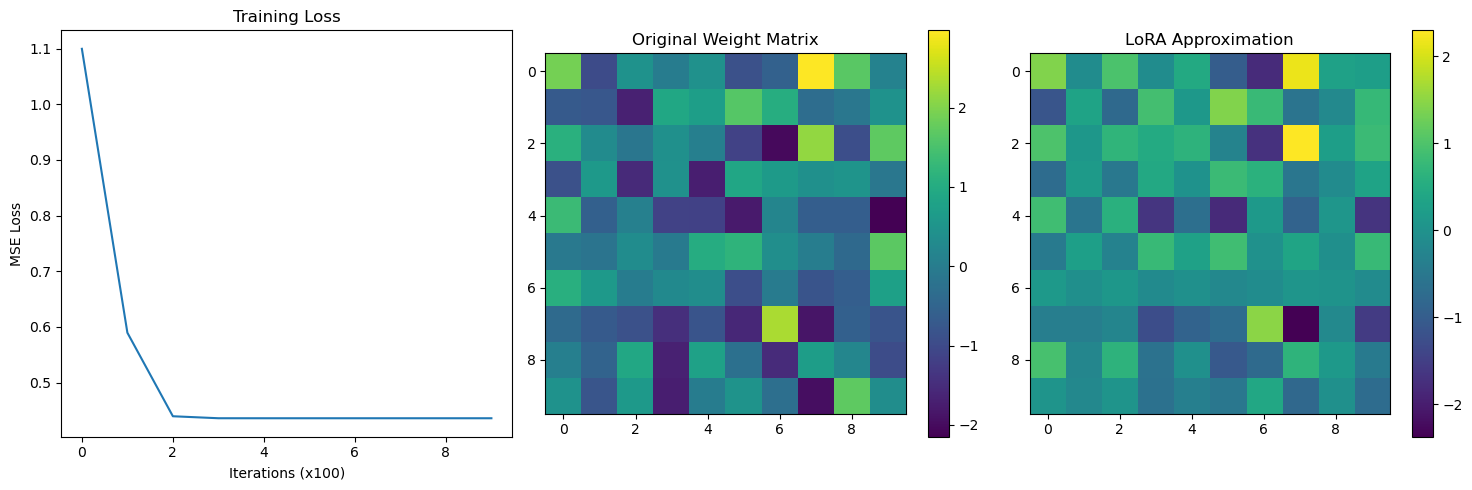


原始权重矩阵的一部分(5x5):
[[ 1.9020243  -0.98042786  0.47197205  0.00751896  0.45111972]
 [-0.6989953  -0.7539018  -1.6730322   0.895078    0.72842824]
 [ 1.1006526   0.32565323 -0.13668585  0.4227683   0.05465927]
 [-0.88375205  0.60963565 -1.5299315   0.43329597 -1.7178423 ]
 [ 1.3465533  -0.571326    0.07685361 -1.1320914  -1.1538632 ]]

LoRA近似后的矩阵的一部分(5x5):
[[ 1.4178535  -0.10202433  0.97077304 -0.0949342   0.46077988]
 [-1.1337396   0.3354595  -0.7775882   0.9027459   0.12311662]
 [ 1.002753    0.09579059  0.6856753   0.4798254   0.6510572 ]
 [-0.72393465  0.1751302  -0.49631235  0.4491832   0.00296068]
 [ 0.8751194  -0.5518392   0.6017585  -1.6507436  -0.66215307]]

误差矩阵的一部分(5x5):
[[ 0.4841708  -0.87840354 -0.498801    0.10245315 -0.00966015]
 [ 0.4347443  -1.0893613  -0.895444   -0.0076679   0.60531163]
 [ 0.09789956  0.22986263 -0.8223612  -0.05705711 -0.59639794]
 [-0.1598174   0.43450546 -1.0336192  -0.01588723 -1.720803  ]
 [ 0.47143394 -0.01948684 -0.52490485  0.5186522  -0.4917101

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1. 创建一个模拟的原始权重矩阵
def create_original_matrix(d=512, k=512):
    """
    创建一个模拟的原始权重矩阵
    d: 输入维度
    k: 输出维度
    """
    original_weight = torch.randn(d, k)  # 随机初始化一个权重矩阵
    return original_weight

# 2. 实现LoRA分解
class LoRALayer:
    def __init__(self, d, k, r):
        """
        d: 输入维度
        k: 输出维度
        r: LoRA秩 (rank)
        """
        self.d = d
        self.k = k
        self.r = r
        
        # 初始化A和B矩阵
        self.lora_A = torch.randn(d, r) / np.sqrt(r)  # 缩放初始化
        self.lora_B = torch.zeros(r, k)  # B初始化为0
        
        # 使其需要梯度
        self.lora_A.requires_grad_(True)
        self.lora_B.requires_grad_(True)

    def forward(self, x):
        """前向传播"""
        return (self.lora_A @ self.lora_B) @ x

    def get_weight_update(self):
        """获取权重更新矩阵"""
        return self.lora_A @ self.lora_B
    
# 3. 演示训练过程
def train_lora(original_weight, lora_layer, num_iterations=1000):
    """
    训练LoRA来近似原始权重矩阵
    Adam是一种优化器，用于更新模型参数
    [lora_layer.lora_A, lora_layer.lora_B]指定需要优化的参数
    lr=0.01是学习率，控制每次更新的步长
    优化器的作用是根据梯度更新A和B矩阵，使得BA的乘积逐渐接近原始权重矩阵
    """
    optimizer = torch.optim.Adam([lora_layer.lora_A, lora_layer.lora_B], lr=0.01)
    losses = []

    for i in range(num_iterations):
        # 计算当前LoRA权重
        current_weight = lora_layer.get_weight_update()
        
        # 计算与原始权重的差异
        # 计算当前LoRA权重与原始权重的差异
        # 使用均方误差损失函数（MSE）来衡量差异
        # 损失函数越小，表示当前LoRA权重越接近原始权重
        loss = torch.nn.functional.mse_loss(current_weight, original_weight)
        
        # 反向传播
        optimizer.zero_grad()  # 清除之前的梯度
        loss.backward()       # 计算梯度
        optimizer.step()      # 根据梯度更新参数
        
        if i % 100 == 0:
            losses.append(loss.item())
            print(f"Iteration {i}, Loss: {loss.item():.6f}")
    
    return losses


# 4. 可视化结果
# 修改可视化函数
def visualize_results(original_weight, lora_approximation, losses):
    plt.figure(figsize=(15, 5))
    
    # 绘制损失曲线
    plt.subplot(131)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('MSE Loss')
    
    # 绘制原始权重矩阵
    plt.subplot(132)
    plt.imshow(original_weight.detach().numpy(), cmap='viridis')
    plt.title('Original Weight Matrix')
    plt.colorbar()
    
    # 绘制LoRA近似后的矩阵
    plt.subplot(133)
    plt.imshow(lora_approximation.detach().numpy(), cmap='viridis')
    plt.title('LoRA Approximation')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    # 打印矩阵数值
    print("\n原始权重矩阵的一部分(5x5):")
    print(original_weight.detach().numpy()[:5, :5])
    
    print("\nLoRA近似后的矩阵的一部分(5x5):")
    print(lora_approximation.detach().numpy()[:5, :5])
    
    # 计算误差矩阵
    error_matrix = original_weight.detach().numpy() - lora_approximation.detach().numpy()
    print("\n误差矩阵的一部分(5x5):")
    print(error_matrix[:5, :5])
    
    # 计算一些统计指标
    print("\n统计指标:")
    print(f"最大误差: {np.abs(error_matrix).max():.6f}")
    print(f"平均误差: {np.abs(error_matrix).mean():.6f}")
    print(f"误差标准差: {np.abs(error_matrix).std():.6f}")
    
    # 计算相似度
    from scipy.stats import pearsonr
    orig_flat = original_weight.detach().numpy().flatten()
    lora_flat = lora_approximation.detach().numpy().flatten()
    correlation, _ = pearsonr(orig_flat, lora_flat)
    print(f"矩阵相似度(相关系数): {correlation:.6f}")
    
# 5. 主函数
def main():
    # 设置维度
    d, k = 10, 10  # 使用较小的维度便于演示
    r = 2  # LoRA秩
    
    # 创建原始权重
    original_weight = create_original_matrix(d, k)
    
    # 创建LoRA层
    lora_layer = LoRALayer(d, k, r)
    
    # 训练LoRA
    losses = train_lora(original_weight, lora_layer)
    
    # 获取最终的LoRA近似
    final_approximation = lora_layer.get_weight_update()
    
    # 计算参数量的节省
    original_params = d * k
    lora_params = r * (d + k)
    reduction = (1 - lora_params/original_params) * 100
    
    print(f"\n原始参数量: {original_params}")
    print(f"LoRA参数量: {lora_params}")
    print(f"参数减少: {reduction:.2f}%")
    
    # 可视化结果
    visualize_results(original_weight, final_approximation, losses)


if __name__ == "__main__":
    main()

<div align=center><img src="https://typora-photo1220.oss-cn-beijing.aliyuncs.com/DataAnalysis/muyan/image-20250311162917012.png" width=100%></div>